# Compute Baseline Metrics for BTC Forecasting

## Setup

In [1]:
import os
import pandas as pd
import torch
from torch.utils.data import Subset
import numpy as np

import tensorflow as tf
import keras
from sklearn.preprocessing import MinMaxScaler

from utils.TSDataset import TimeSeriesDataset
from utils.TSDataset import data_load
from utils.plot import *
from utils.split_train_val_test import split_train_val_test, extract_from_subset
from utils.compute_metric import compute_metrics, append_score

from torch.utils.data import DataLoader

import matplotlib as mpl
import matplotlib.pyplot as plt


In [2]:
project_dir = os.path.dirname(os.path.abspath('__file__'))
project_dir

data_path = os.path.join(project_dir, 'data', 'processed', 'BTC-USD-sample.csv')

# Load data
data1, x_scaler1, y_scaler1 = data_load(data_path, x_scaler='minmax', y_scaler='minmax')

n = len(data1)
train_df = data1.iloc[:int(0.7 * n)].sort_index()
val_df   = data1.iloc[int(0.7 * n):int(0.85 * n)].sort_index()
test_df  = data1.iloc[int(0.85 * n):].sort_index()

## Naive Forecasting Models

In [13]:
scores = []
target_col = 'y'

# Evaluate Naive Model Loss on Full Dataset
test_target = data1[target_col].values
naive_y_pred = test_target[:-1]
naive_y_true = test_target[1:]

naive_y_pred = naive_y_pred.reshape(-1, 1)
naive_y_pred = y_scaler1.inverse_transform(naive_y_pred)
naive_y_pred = naive_y_pred.flatten()
naive_y_true = naive_y_true.reshape(-1, 1)
naive_y_true = y_scaler1.inverse_transform(naive_y_true)
naive_y_true = naive_y_true.flatten()

mse_naive, mae_naive, huber_naive = compute_metrics(naive_y_true, naive_y_pred)
naive_scores = {
    'model': 'Naive',
    'mse': mse_naive,
    'mae': mae_naive,
    'huber': huber_naive
}
append_score(scores, naive_scores)

print("Naive 1-step Forecast -> MSE: {:.4f}, MAE: {:.4f}, Huber: {:.4f}".format(mse_naive, mae_naive, huber_naive))

Naive 1-step Forecast -> MSE: 1359.5668, MAE: 27.2615, Huber: 26.8045


## Linear Model

- Test Evaluation Steps:
    1. Train
    2. Evaluate on validation to ensure no overfitting
    3. Evaluate in test set
    4. Store test set results
    5. Plot loss

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
Dense Model 1-step Forecast -> MSE: 1210.9476, MAE: 26.8236, Huber: 26.3273


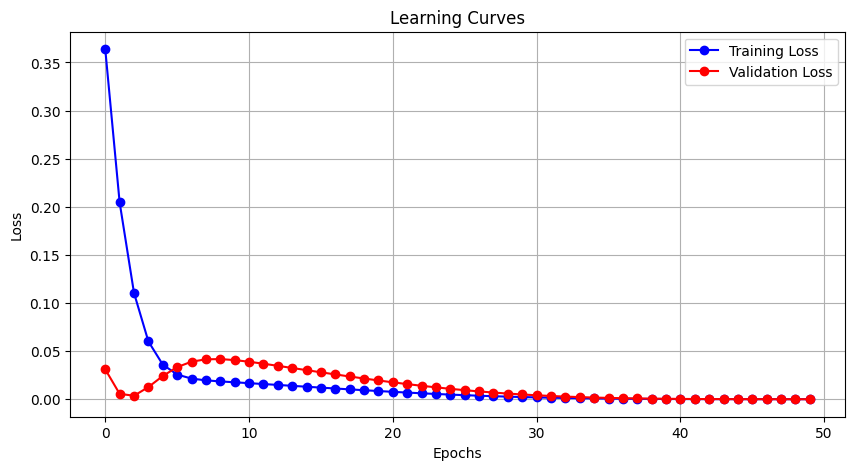

In [14]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Train Dense Model
X_train_dense = train_df[target_col].values[:-1].reshape(-1, 1)
y_train_dense = train_df[target_col].values[1:].reshape(-1, 1)

X_val_dense = val_df[target_col].values[:-1].reshape(-1, 1)
y_val_dense = val_df[target_col].values[1:].reshape(-1, 1)

dense_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tf.keras.layers.Dense(1)
])

dense_model.compile(optimizer='adam', loss='mse', metrics=['mae'],)
history =dense_model.fit(X_train_dense, y_train_dense, epochs=50, verbose=0,
                         validation_data=(X_val_dense, y_val_dense))


# Validation Set to ensure model is not overfitting
y_pred_dense = dense_model.predict(X_val_dense).reshape(-1,1)
y_pred_dense = y_scaler1.inverse_transform(y_pred_dense)
y_pred_dense = y_pred_dense.flatten()

y_val_dense = y_val_dense.reshape(-1,1)
y_val_dense = y_scaler1.inverse_transform(y_val_dense)
y_val_dense = y_val_dense.flatten()

# Compute Metrics
mse_dense, mae_dense, huber_dense = compute_metrics(y_val_dense, y_pred_dense)

print("Dense Model 1-step Forecast -> MSE: {:.4f}, MAE: {:.4f}, Huber: {:.4f}".format(mse_dense, mae_dense, huber_dense))
plot_learning_curves(history.history)

In [28]:
target_col = 'y'
window_size = 50
forecast_horizon = 1

def format_forecast_plot(data_frame, target_col, model, window_size, forecast_horizon):
    start_idx = np.random.randint(0, len(data_frame) - window_size - forecast_horizon)

    # Historical sequence
    last_train = data_frame[target_col].values[start_idx : start_idx + window_size]

    # Target Sequence
    target_sequence = data_frame[target_col].values[start_idx + window_size : start_idx + window_size + forecast_horizon]
    target_sequence = target_sequence.reshape(-1, 1)

    # Predicted Sequence
    y_pred = model.predict(X_val_dense).reshape(-1, 1)
    prediction_sequence = y_pred[start_idx + window_size - 1 : start_idx + window_size - 1 + forecast_horizon].flatten()

    return last_train, target_sequence, prediction_sequence

last_train, target_sequence, prediction_sequence = format_forecast_plot(val_df, target_col, dense_model, window_size, forecast_horizon)

# Plot the forecast using your plotting function.
#plot_forecast(last_train, target_sequence, prediction_sequence, scaler=y_scaler1)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step


In [21]:
# Evaluate Model Performance on Test Set
X_test_dense  = test_df[target_col].values[:-1].reshape(-1, 1)
y_test_dense  = test_df[target_col].values[1:].reshape(-1, 1)

y_pred_dense = dense_model.predict(X_test_dense).reshape(-1,1)
y_pred_dense = y_scaler1.inverse_transform(y_pred_dense)
y_pred_dense = y_pred_dense.flatten()

y_test_dense = y_test_dense.reshape(-1,1)
y_test_dense = y_scaler1.inverse_transform(y_test_dense)
y_test_dense = y_test_dense.flatten()

mse_dense, mae_dense, huber_dense = compute_metrics(y_test_dense, y_pred_dense)

# Store Test Set Scores
dense_scores = {
    'model': 'Dense',
    'mse': mse_dense,
    'huber': huber_dense
}

append_score(scores, dense_scores)
print("Dense Model 1-step Forecast -> MSE: {:.4f}, MAE: {:.4f}, Huber: {:.4f}".format(mse_dense, mae_dense, huber_dense))

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step
Dense Model 1-step Forecast -> MSE: 1161.0741, MAE: 24.8000, Huber: 24.3218


## Simple Recurrent Neural Network

In [22]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

feature_cols = ['x1', 'x2', 'x3', 'x4', 'x5']
forecast_horizon = 1
window_size = 50

train_dataset_rnn = TimeSeriesDataset(train_df, window_size, forecast_horizon, feature_cols, target_col)
val_dataset_rnn   = TimeSeriesDataset(val_df, window_size, forecast_horizon, feature_cols, target_col)
test_dataset_rnn  = TimeSeriesDataset(test_df, window_size, forecast_horizon, feature_cols, target_col)

,y,x1,x2,x3,x4,x5
date,,,,,,
2017-12-28 12:40:00,0.637228,0.103401,0.110460,0.626714,0.640365,0.635941
2017-12-28 12:41:00,0.652562,0.240797,0.258083,0.645801,0.647049,0.648613
2017-12-28 12:42:00,0.659211,0.021149,0.022699,0.654392,0.655973,0.660166
2017-12-28 12:43:00,0.673142,0.092292,0.099353,0.659437,0.667738,0.668418
2017-12-28 12:44:00,0.664504,0.059115,0.063520,0.673373,0.667738,0.665550


In [29]:
train_loader_rnn = DataLoader(train_dataset_rnn, batch_size=20, shuffle=False)

# Define RNN Model
rnn_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(16, input_shape=(window_size, len(feature_cols))),
    tf.keras.layers.Dense(forecast_horizon)
])

# Prepare Training Data
X_train_rnn = train_dataset_rnn.X_seq.numpy()
y_train_rnn = train_dataset_rnn.y_seq.numpy()

# Prepare Validation Data
X_val_rnn = val_dataset_rnn.X_seq.numpy()
y_val_rnn = val_dataset_rnn.y_seq.numpy()

# Compile Model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
rnn_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Train Model
history = rnn_model.fit(X_train_rnn, y_train_rnn, epochs=60, verbose=0,
                        validation_data=(X_val_rnn, y_val_rnn))

# Evaluate Model on Training Set
y_pred_rnn = rnn_model.predict(X_train_rnn)

# Rescale Predictions to Real Values
y_pred_rnn = y_scaler1.inverse_transform(y_pred_rnn)
y_pred_rnn = y_pred_rnn.flatten()

# Rescale Target Values to Real Values
y_train_rnn = y_train_rnn.reshape(-1, 1)
y_train_rnn = y_scaler1.inverse_transform(y_train_rnn)
y_train_rnn = y_train_rnn.flatten()

# Compute Metrics
mse_rnn, mae_rnn, huber_rnn = compute_metrics(y_train_rnn, y_pred_rnn)

print("RNN Sequence-to-Vector (horizon=10) -> MSE: {:.4f}, MAE: {:.4f}, Huber: {:.4f}".format(mse_rnn, mae_rnn, huber_rnn))
#plot_learning_curves(history.history)

/Users/jeddyxie/CNN-LSTM/CNN-LSTM/venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
RNN Sequence-to-Vector (horizon=10) -> MSE: 3642.0203, MAE: 44.4226, Huber: 43.9255


In [26]:
last_train, target_sequence, prediction_sequence = format_forecast_plot(val_df, target_col, rnn_model, window_size, forecast_horizon)

plot_forecast(last_train, target_sequence, prediction_sequence, scaler=y_scaler1)

ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None

In [11]:
# Test Set to evaluate model performance
X_test_rnn  = test_dataset_rnn.X_seq.numpy()
y_test_rnn  = test_dataset_rnn.y_seq.numpy()

y_pred_rnn = rnn_model.predict(X_test_rnn).reshape(-1,1)
y_pred_rnn = y_scaler1.inverse_transform(y_pred_rnn)
y_pred_rnn = y_pred_rnn.flatten()

y_test_rnn = y_test_rnn.reshape(-1,1)
y_test_rnn = y_scaler1.inverse_transform(y_test_rnn)
y_test_rnn = y_test_rnn.flatten()

print(f"First five predictions: {y_pred_rnn[:5]}")
print(f"First five actual values: {y_test_rnn[:5]}")

mse_rnn, mae_rnn, huber_rnn = compute_metrics(y_test_rnn, y_pred_rnn)

rnn_scores = {
    'model': 'RNN',
    'mse': mse_rnn,
    'mae': mae_rnn,
    'huber': huber_rnn
}

scores.append(rnn_scores)
print("RNN Model 1-step Forecast -> MSE: {:.4f}, MAE: {:.4f}, Huber: {:.4f}".format(mse_rnn, mae_rnn, huber_rnn))

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
First five predictions: [13122.002 13092.414 13089.299 13019.939 13127.003]
First five actual values: [13038.079 13090.29  13079.3   13078.24  13090.26 ]
RNN Model 1-step Forecast -> MSE: 1541.6320, MAE: 30.9023, Huber: 30.4057


## Deep RNN

In [12]:
# Create TimeSeriesDataset objects for train, validation, and test sets.
train_dataset_deep_rnn = TimeSeriesDataset(train_df, window_size, forecast_horizon, feature_cols, target_col)
val_dataset_deep_rnn   = TimeSeriesDataset(val_df, window_size, forecast_horizon, feature_cols, target_col)
test_dataset_deep_rnn  = TimeSeriesDataset(test_df, window_size, forecast_horizon, feature_cols, target_col)

# Create a DataLoader for training (for batched iteration if needed).
train_loader_deep_rnn = DataLoader(train_dataset_deep_rnn, batch_size=18, shuffle=False)

deep_rnn_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(20, return_sequences=True, input_shape=(window_size, len(feature_cols))),
    tf.keras.layers.SimpleRNN(20, return_sequences=True),
    tf.keras.layers.SimpleRNN(20, return_sequences=False),
    tf.keras.layers.Dense(forecast_horizon)
])

# Prepare training and validation data as NumPy arrays.
X_train_deep_rnn = train_dataset_deep_rnn.X_seq.numpy()
y_train_deep_rnn = train_dataset_deep_rnn.y_seq.numpy()

X_val_deep_rnn = val_dataset_deep_rnn.X_seq.numpy()
y_val_deep_rnn = val_dataset_deep_rnn.y_seq.numpy()

# Define an optimizer and compile the model.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
deep_rnn_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Train the model.
history = deep_rnn_model.fit(X_train_deep_rnn, y_train_deep_rnn, epochs=60, verbose=0,
                             validation_data=(X_val_deep_rnn, y_val_deep_rnn))

# Evaluate model predictions on the training set.
y_pred_deep_rnn = deep_rnn_model.predict(X_train_deep_rnn)

# Rescale Predictions to real values using your scaler (assume y_scaler1 is a fitted scaler).
y_pred_deep_rnn = y_scaler1.inverse_transform(y_pred_deep_rnn)
y_pred_deep_rnn = y_pred_deep_rnn.flatten()

# Rescale target values.
y_train_deep_rnn = y_train_deep_rnn.reshape(-1, 1)
y_train_deep_rnn = y_scaler1.inverse_transform(y_train_deep_rnn)
y_train_deep_rnn = y_train_deep_rnn.flatten()

# Compute evaluation metrics (MSE, MAE, Huber Loss). Assume compute_metrics is defined.
mse_deep_rnn, mae_deep_rnn, huber_deep_rnn = compute_metrics(y_train_deep_rnn, y_pred_deep_rnn)

print("Deep RNN Sequence-to-Vector (horizon=1) -> MSE: {:.4f}, MAE: {:.4f}, Huber: {:.4f}".format(
      mse_deep_rnn, mae_deep_rnn, huber_deep_rnn))

/Users/jeddyxie/CNN-LSTM/CNN-LSTM/venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Deep RNN Sequence-to-Vector (horizon=1) -> MSE: 2568.1443, MAE: 38.7642, Huber: 38.2670


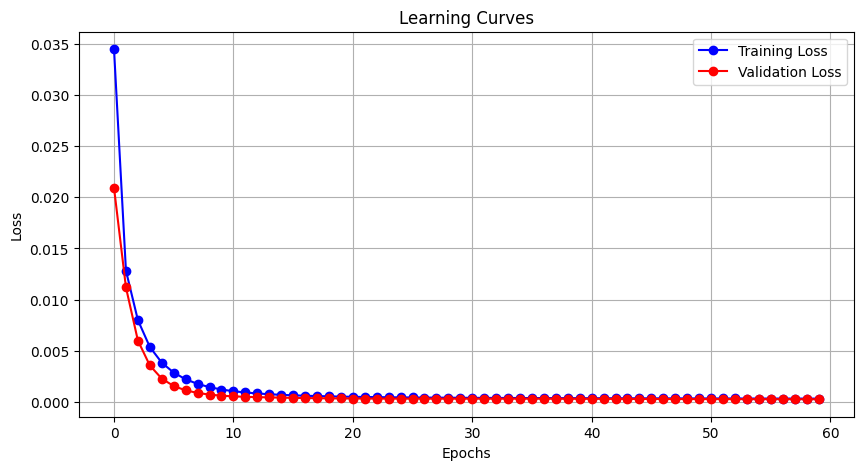

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


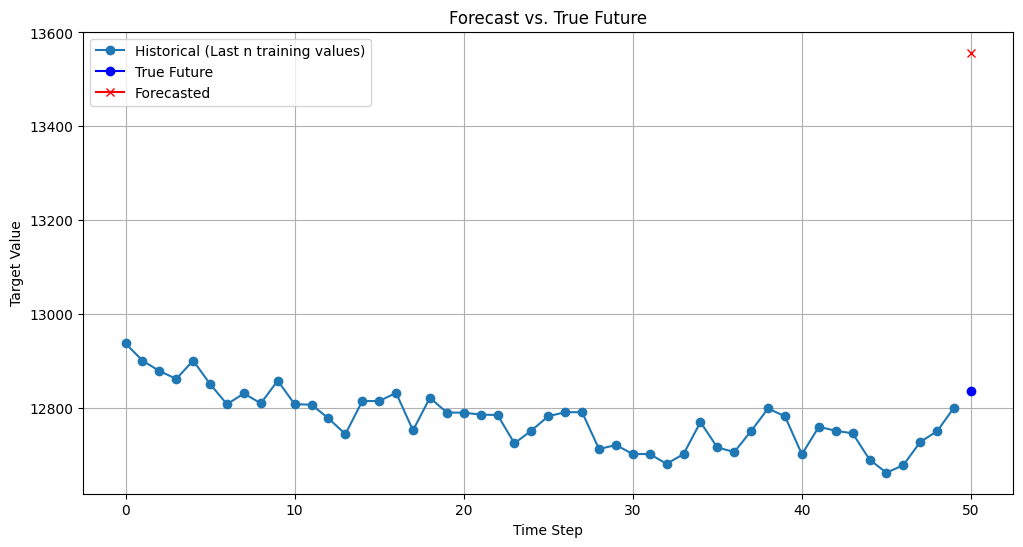

In [13]:
plot_learning_curves(history.history)

target_col = 'y'
window_size = 50
forecast_horizon = 1

# Pick a start index ensuring enough room for both window and future
start_idx = np.random.randint(0, len(val_df) - window_size - forecast_horizon)

# Historical sequence
last_train = val_df[target_col].values[start_idx : start_idx + window_size]

# Target Sequence
true_future = val_df[target_col].values[start_idx + window_size : start_idx + window_size + forecast_horizon]
true_future = true_future.reshape(-1, 1)

# Predicted Sequence
y_pred_dense = dense_model.predict(X_val_dense).reshape(-1, 1)
predicted_future = y_pred_dense[start_idx + window_size - 1 : start_idx + window_size - 1 + forecast_horizon].flatten()

# Plot the forecast using your plotting function.
plot_forecast(last_train, true_future, predicted_future, scaler=y_scaler1)

# Multi-step forecasting

In [54]:
# Naive Forecast
window_size = 50
forecast_horizon = 60 
feature_cols = ['x1', 'x2', 'x3', 'x4', 'x5']
target_col = 'y'

# Create datasets for each split
train_dataset = TimeSeriesDataset(train_df, window_size, forecast_horizon, feature_cols, target_col)
val_dataset   = TimeSeriesDataset(val_df, window_size, forecast_horizon, feature_cols, target_col)
test_dataset  = TimeSeriesDataset(test_df, window_size, forecast_horizon, feature_cols, target_col)

scores = []

test_target = test_df[target_col].values
naive_y_true = test_target[1:]
naive_y_pred = np.full_like(naive_y_true, test_target[0])

naive_y_pred = naive_y_pred.reshape(-1, 1)
naive_y_pred = y_scaler1.inverse_transform(naive_y_pred)
naive_y_pred = naive_y_pred.flatten()
naive_y_true = naive_y_true.reshape(-1, 1)
naive_y_true = y_scaler1.inverse_transform(naive_y_true)
naive_y_true = naive_y_true.flatten()

mse_naive, mae_naive, huber_naive = compute_metrics(naive_y_true, naive_y_pred)
naive_scores = {
    'model': 'Naive-60',
    'mse': mse_naive,
    'mae': mae_naive,
    'huber': huber_naive
}
scores.append(naive_scores)

print("Naive 60-step Forecast -> MSE: {:.4f}, MAE: {:.4f}, Huber: {:.4f}".format(mse_naive, mae_naive, huber_naive))

Naive 60-step Forecast -> MSE: 437832.6442, MAE: 559.1110, Huber: 558.6111


## Deep RNN

In [55]:
# 60-step forecasting
forecast_horizon = 10

# Create TimeSeriesDataset objects for train, validation, and test sets.
train_dataset_deep_rnn = TimeSeriesDataset(train_df, window_size, forecast_horizon, feature_cols, target_col)
val_dataset_deep_rnn   = TimeSeriesDataset(val_df, window_size, forecast_horizon, feature_cols, target_col)
test_dataset_deep_rnn  = TimeSeriesDataset(test_df, window_size, forecast_horizon, feature_cols, target_col)

# Create a DataLoader for training (for batched iteration if needed).
train_loader_deep_rnn = DataLoader(train_dataset_deep_rnn, batch_size=18, shuffle=False)

deep_rnn_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(20, return_sequences=True, input_shape=(window_size, len(feature_cols))),
    tf.keras.layers.SimpleRNN(20, return_sequences=True),
    tf.keras.layers.SimpleRNN(20, return_sequences=False),
    tf.keras.layers.Dense(forecast_horizon)
])

# Prepare training and validation data as NumPy arrays.
X_train_deep_rnn = train_dataset_deep_rnn.X_seq.numpy()
y_train_deep_rnn = train_dataset_deep_rnn.y_seq.numpy()

X_val_deep_rnn = val_dataset_deep_rnn.X_seq.numpy()
y_val_deep_rnn = val_dataset_deep_rnn.y_seq.numpy()

# Define an optimizer and compile the model.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
deep_rnn_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Train the model.
history = deep_rnn_model.fit(X_train_deep_rnn, y_train_deep_rnn, epochs=60, verbose=0,
                             validation_data=(X_val_deep_rnn, y_val_deep_rnn))

# Evaluate model predictions on the training set.
y_pred_deep_rnn = deep_rnn_model.predict(X_train_deep_rnn)

# Rescale Predictions
y_pred_deep_rnn = y_scaler1.inverse_transform(y_pred_deep_rnn)
y_pred_deep_rnn_flattened = y_pred_deep_rnn.flatten()

# Rescale Target Values
y_train_deep_rnn = y_train_deep_rnn.reshape(-1, 1)
y_train_deep_rnn = y_scaler1.inverse_transform(y_train_deep_rnn)
y_train_deep_rnn = y_train_deep_rnn.flatten()

# Compute Metrics
mse_deep_rnn, mae_deep_rnn, huber_deep_rnn = compute_metrics(y_train_deep_rnn, y_pred_deep_rnn_flattened)

print("Deep RNN Sequence-to-Vector (horizon=1) -> MSE: {:.4f}, MAE: {:.4f}, Huber: {:.4f}".format(
      mse_deep_rnn, mae_deep_rnn, huber_deep_rnn))

/Users/jeddyxie/CNN-LSTM/CNN-LSTM/venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Deep RNN Sequence-to-Vector (horizon=1) -> MSE: 8358.6006, MAE: 68.4930, Huber: 67.9947


In [56]:
print(y_pred_deep_rnn[0])

[14276.371 14294.517 14316.708 14291.945 14302.753 14274.929 14295.419
 14266.225 14271.495 14311.23 ]


In [71]:
target_col = 'y'
window_size = 50
forecast_horizon = 10

start_idx = 0

# Extract the sample from the dataset.
# Each sample is a tuple: (X_seq, y_seq, x_date, y_date)
sample = val_dataset_deep_rnn[start_idx]
X_sample, y_target_sequence, x_date, y_date = sample

historical_sequence = val_df[target_col].values[start_idx:start_idx+window_size]
print(historical_sequence[:5])

# Check if target sequence = historical sequence

print(y_target_sequence[start_idx:start_idx+5])





[0.2559106  0.25192753 0.25192753 0.26632377 0.26962194]
tensor([0.2396, 0.2253, 0.2414, 0.2361, 0.2207])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


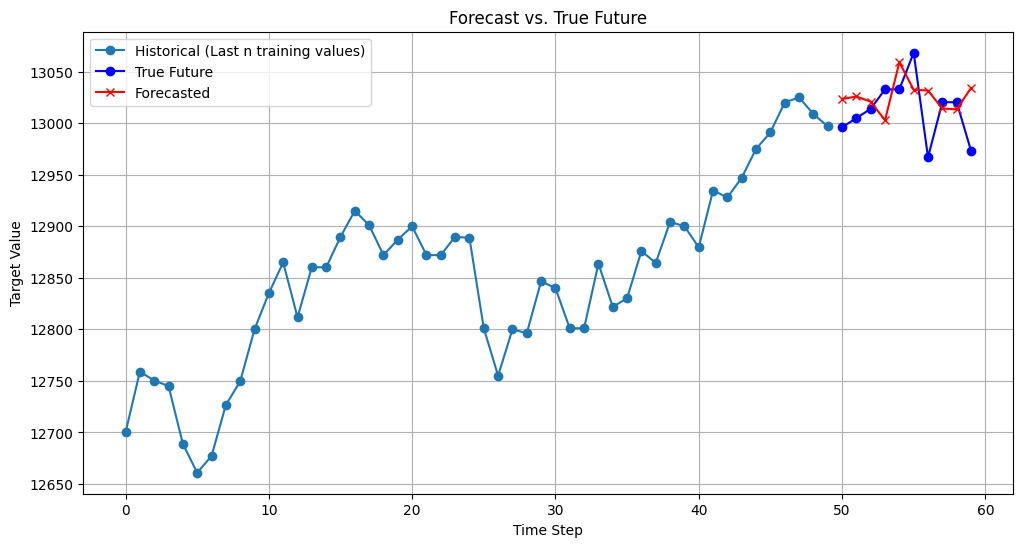

In [99]:
target_col = 'y'
window_size = 50
forecast_horizon = 10

# Select a random sample index from the validation dataset.
sample_idx = np.random.randint(0, len(val_dataset_deep_rnn))

# Extract the sample from the dataset.
# Each sample is a tuple: (X_seq, y_seq, x_date, y_date)
sample = val_dataset_deep_rnn[sample_idx]
X_sample, y_true_sample, x_date, y_date = sample

# Instead of extracting historical values from X_sample (which only has x1-x5),
# get the historical target values (actual y) directly from the original DataFrame.
historical_sequence = val_df[target_col].values[sample_idx : sample_idx + window_size]

# The true future values (target) for this sample (should have shape (forecast_horizon, 1))
target_sequence = y_true_sample.reshape(-1, 1)

# Prepare X_sample for prediction by adding a batch dimension.
X_sample_input = np.expand_dims(X_sample, axis=0)

# Predict the forecast for the sample using the deep RNN model.
y_pred_sample = deep_rnn_model.predict(X_sample_input)  # expected shape: (1, forecast_horizon)
y_pred_sample = y_pred_sample.reshape(-1, 1)

# Inverse-scale the predictions, target sequence, and historical sequence.
y_pred_sample = y_scaler1.inverse_transform(y_pred_sample).flatten()
target_sequence = y_scaler1.inverse_transform(target_sequence).flatten()
historical_sequence_inv = y_scaler1.inverse_transform(historical_sequence.reshape(-1, 1)).flatten()

forecast_start_index = window_size

# Plot the forecast.
plot_forecast(
    last_train=historical_sequence_inv, 
    true_future=target_sequence, 
    predicted_future=y_pred_sample, 
    scaler=None,   # Already inverse-transformed.
    forecast_start_index=forecast_start_index
)
